# Lab 4. Data structures and arrays
#### Computational Methods for Geoscience - EPS 400/522
#### Instructor: Eric Lindsey

Due: Sept. 21, 2023

---------

Adrian Marziliano

In [1]:
# some useful imports and settings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import datetime
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from scipy.ndimage import zoom


%config InlineBackend.figure_format = 'retina' # better looking figures on high-resolution screens

### Using data structures to categorize data

The file 'worldwide_m4+_2022.csv' (on canvas) contains all earthquakes larger than magnitude 4 recorded by the USGS in 2022 (more than 15,000 events). Let's use a dictionary to keep track of how many events happened in each state.

First, read the data into python using pandas. The column 'place' contains a short description of the location of each event, and if it occurred in the US, this description will (usually) mention a state name. We can find out if a string is contained in another string using the keyword 'in' (see the notes).

Instructions: loop over the list of state names, and for each state count the number of M4+ earthquakes that occurred in that state (you may need to loop over the whole dataset for each state name). Add this number to a dictionary with the state name as the key; for example it might contain 'New Mexico': 4.

Finally, print out the top 10 states by number of earthquakes in 2022.

In [18]:
import pandas as pd

# Step 1: Read the data into Python using pandas
data = pd.read_csv('worldwide_m4+_2022.csv')

# Step 2: Create an empty dictionary to store earthquake counts for each state
earthquake_counts = {}

# Step 3: Loop over the list of state names
state_names = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

for state in state_names:
    # Step 4: Loop over the dataset for each state name
    state_earthquakes = data[data['place'].str.contains(state, case=False, na=False)]
    
    # Step 5: Count the number of earthquakes in the state and store it in the dictionary
    earthquake_counts[state] = len(state_earthquakes)

# Step 6: Print out the top 10 states by the number of earthquakes
top_states = sorted(earthquake_counts.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 States by Number of Earthquakes in 2022:")
for state, count in top_states:
    print(f"{state}: {count} earthquakes")


Top 10 States by Number of Earthquakes in 2022:
Alaska: 401 earthquakes
Oregon: 23 earthquakes
Hawaii: 19 earthquakes
Texas: 12 earthquakes
Georgia: 10 earthquakes
New Mexico: 9 earthquakes
California: 4 earthquakes
Colorado: 3 earthquakes
Nevada: 3 earthquakes
Arizona: 1 earthquakes


### Resampling a dataset

Often times, our data have values missing, large errors, or are unevenly sampled. In this case, we need to 'resample' the data onto a regular grid. This is also known as 'gridding' the data.

Text(0.5, 1.0, 'Original Data')

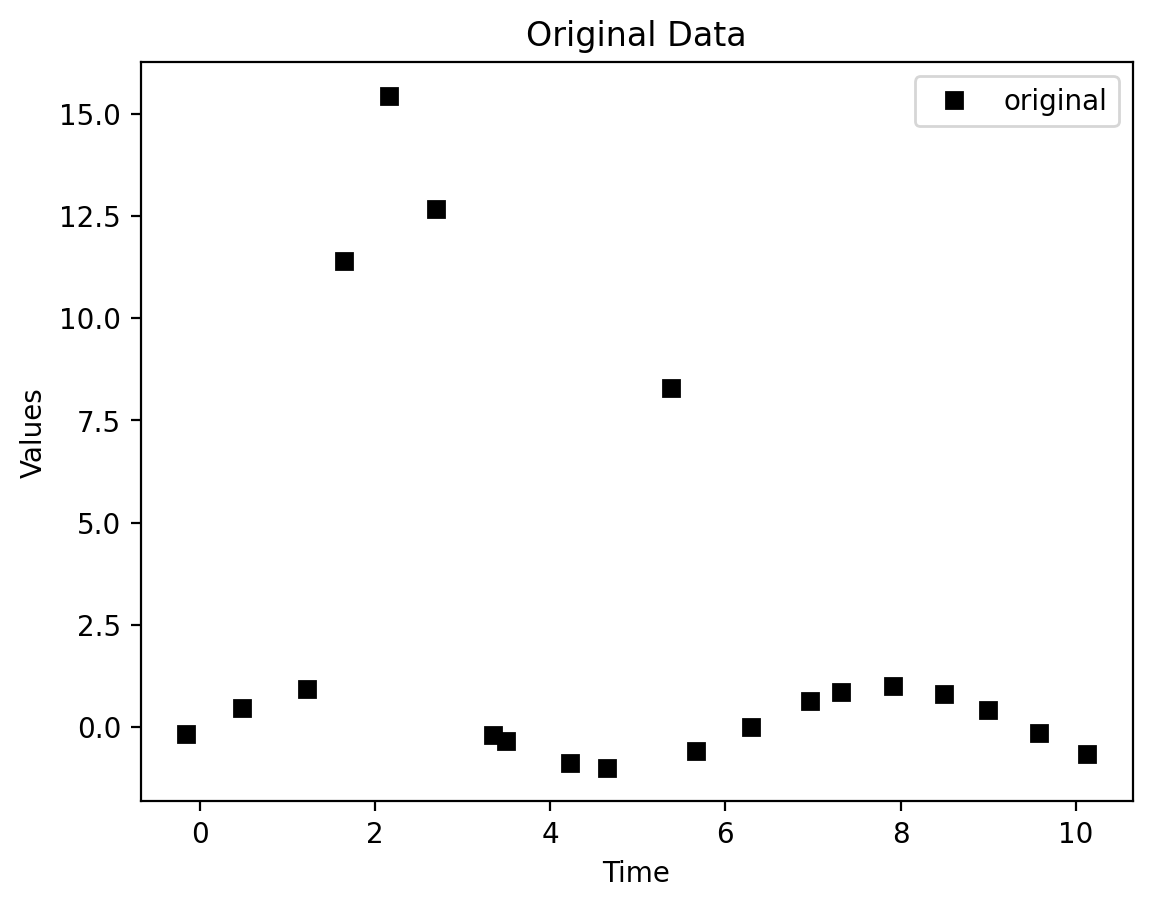

In [69]:
# original data - slight variation in the time sampling
time = np.linspace(0, 10, 20) +  np.random.uniform(-0.2, 0.2, 20)
values = np.sin(time)

# add some bad data
ibad=np.random.randint(2,18,(4,))
values[ibad] += 5+10*np.random.rand(4)

# Print time and data values
#print(time)
#print(values)

# plot the data
plt.plot(time,values,'ks', label='original')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Original Data')

## Assignment 1: remove outliers and resample the above data 

Step 1. Remove the outliers using logical indexing.

Step 2. Resample the remaining data onto a regularly spaced set of points sampled every 0.1 seconds, from 0 to 10. You can choose the interpolation method you find best!

Step 3. Plot the resampled data on top of the original data (without outliers), showing how the interpolation works.

STEP 1: Remove Outliers

Text(0.5, 1.0, 'Outliers Removed')

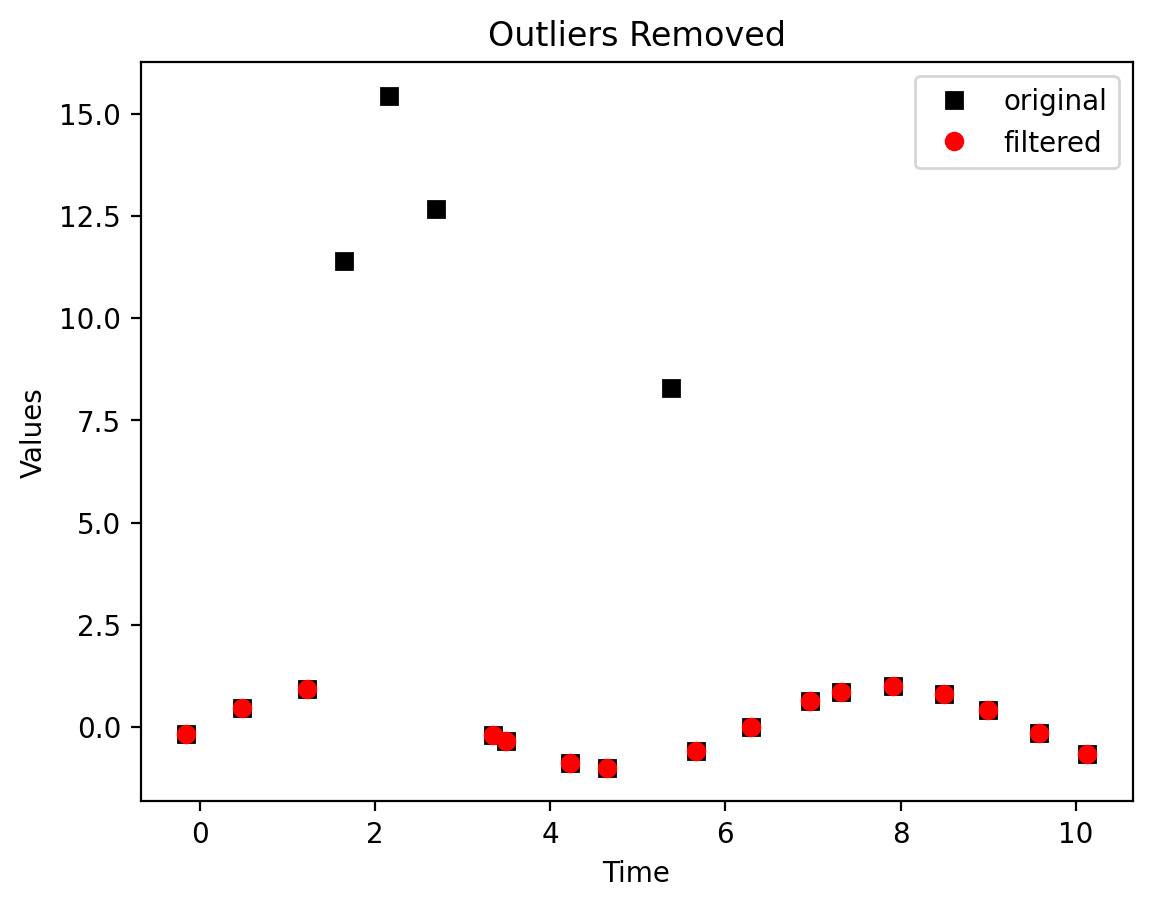

In [70]:
# Calculate mean and standard deviation
mean_value = np.mean(values)
std_dev = np.std(values)

# Define a threshold for outliers (for example, 3 standard deviations from the mean)
threshold = 1 * std_dev

# Use logical indexing to remove outliers
filtered_data = values[abs(values - mean_value) < threshold]
filtered_time = time[abs(values - mean_value) < threshold]

# Print the filtered data
#print("Original data:", values)
#print("Filtered data without outliers:", filtered_data)

# Plot original and filtered data
plt.plot(time, values,'ks', label='original')
plt.plot(filtered_time, filtered_data, 'ro', label='filtered')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Outliers Removed')


STEP 2: Resample Data

In [71]:
# Define the regularly spaced set of points sampled every 0.1 seconds from 0 to 10
resampled_time = np.arange(0, 10.1, 0.1)

# Use linear interpolation to resample the data
resampled_data = np.interp(resampled_time, filtered_time, filtered_data)

# Print the resampled data
#print("Resampled Time Values:", resampled_time)
#print("Resampled Data Values:", resampled_data)



STEP 3: Plot Original and Resampled Data

Text(0.5, 1.0, 'Resampled Data vs Original')

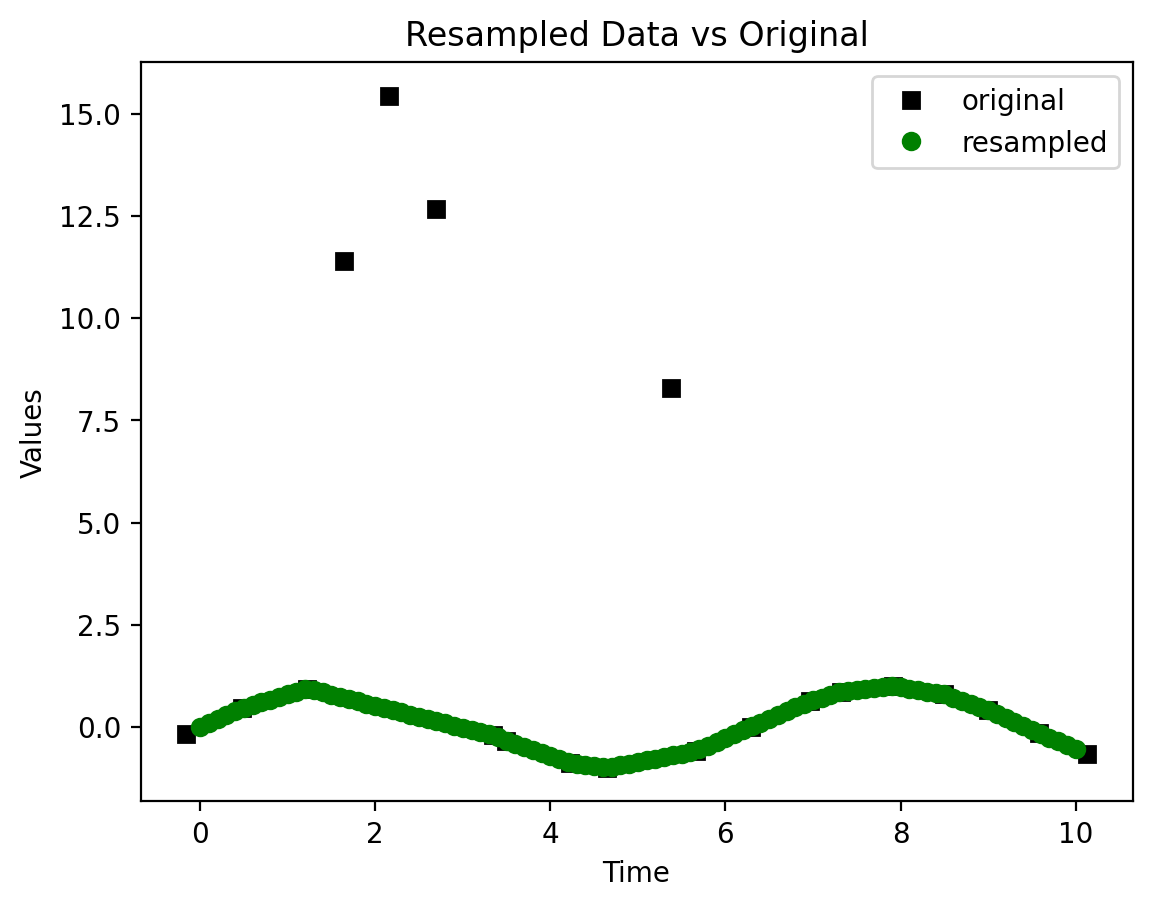

In [72]:
# Plot Data
plt.plot(time,values,'ks', label='original')
plt.plot(resampled_time, resampled_data, 'go', label='resampled')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Resampled Data vs Original')

## Assignment 2. Use 2D Interpolation to fill in the continents.

Remember our averaged-monthly SST dataset? (Filename: 'sst.mon.ltm.1981-2010.nc') Let's use this as a (strange) example of interpolation. Try masking out the NaNs in the grid of temperatures from September, then use griddata to fill in all the values over the continents.

I think this will prove a litte challenging - good luck, work with each other!

In [35]:
# here is some code to get you started.
# note you will have to copy the data file into your current folder for it to work for you.

filename = 'sst.mon.ltm.1981-2010.nc'
dataset = nc.Dataset(filename)

# sst is stored as a 3D array (time,lat,lon)
# get the grid in September
sst_sept = dataset['sst'][8,:,:]

# Hint: note that this netCDF dataset comes with a 'mask' property that lets us know which values are NaN.
# we can access them with sst_sept.mask
print('whether each point is nan:\n',sst_sept.mask)

# you can use this to extract only the valid data from any given array, if it has the same size
zvalid = sst_sept[~sst_sept.mask]

# check the shapes:
print('shape of sst_sept is', np.shape(sst_sept))
# notice, now it became a vector instead of an array.
print('shape of zvalid is', np.shape(zvalid))


whether each point is nan:
 [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
shape of sst_sept is (180, 360)
shape of zvalid is (43799,)


#### I suggest the following procedure:

**STEPS BELOW...**

**STEP 1: Generate the gridded X and Y matrices**

Use np.meshgrid on the dataset['lon'] and dataset['lat'] vectors.
Make sure to verify that your output arrays have the same size as your SST data.

In [175]:
# Open the netCDF dataset
dataset = nc.Dataset('sst.mon.ltm.1981-2010.nc')

# Access the 'lon' and 'lat' vectors
lon = dataset['lon'][:]
lat = dataset['lat'][:]

# Create gridded X and Y matrices using np.meshgrid
lon_mesh, lat_mesh = np.meshgrid(lon, lat)

# get the grid in September
sst_sept = dataset['sst'][8,:,:] # September data

# Access the 'mask' variable
mask = sst_sept.mask # Mask data for September

# Use the mask to filter out NaN values in sst_sept
masked_sst_sept = np.ma.masked_where(mask, sst_sept)


**Step 2. Extract the valid points from each of your 3 arrays (X, Y, SST)**

Check out the hint above for how to use the mask property of the netcdf dataset.

In [176]:
# Use the mask to filter out NaN values in sst_sept
masked_sst_sept = np.ma.masked_where(mask, sst_sept)

# Extract valid SST points from the X, Y, and SST arrays
valid_lon = lon_mesh[~masked_sst_sept.mask]
valid_lat = lat_mesh[~masked_sst_sept.mask]
valid_sst_sept = masked_sst_sept[~masked_sst_sept.mask]

# Create a grid of points for interpolation (the full X and Y grids)
full_lon_mesh, full_lat_mesh = np.meshgrid(lon, lat)

**Step 3. Choose an interpolation method and do the interpolation from the scattered valid data back to the full X and Y grids**

In [177]:
# Perform interpolation using griddata
interpolated_sst_sept = griddata((valid_lon, valid_lat), valid_sst_sept, (full_lon_mesh, full_lat_mesh), method='linear')

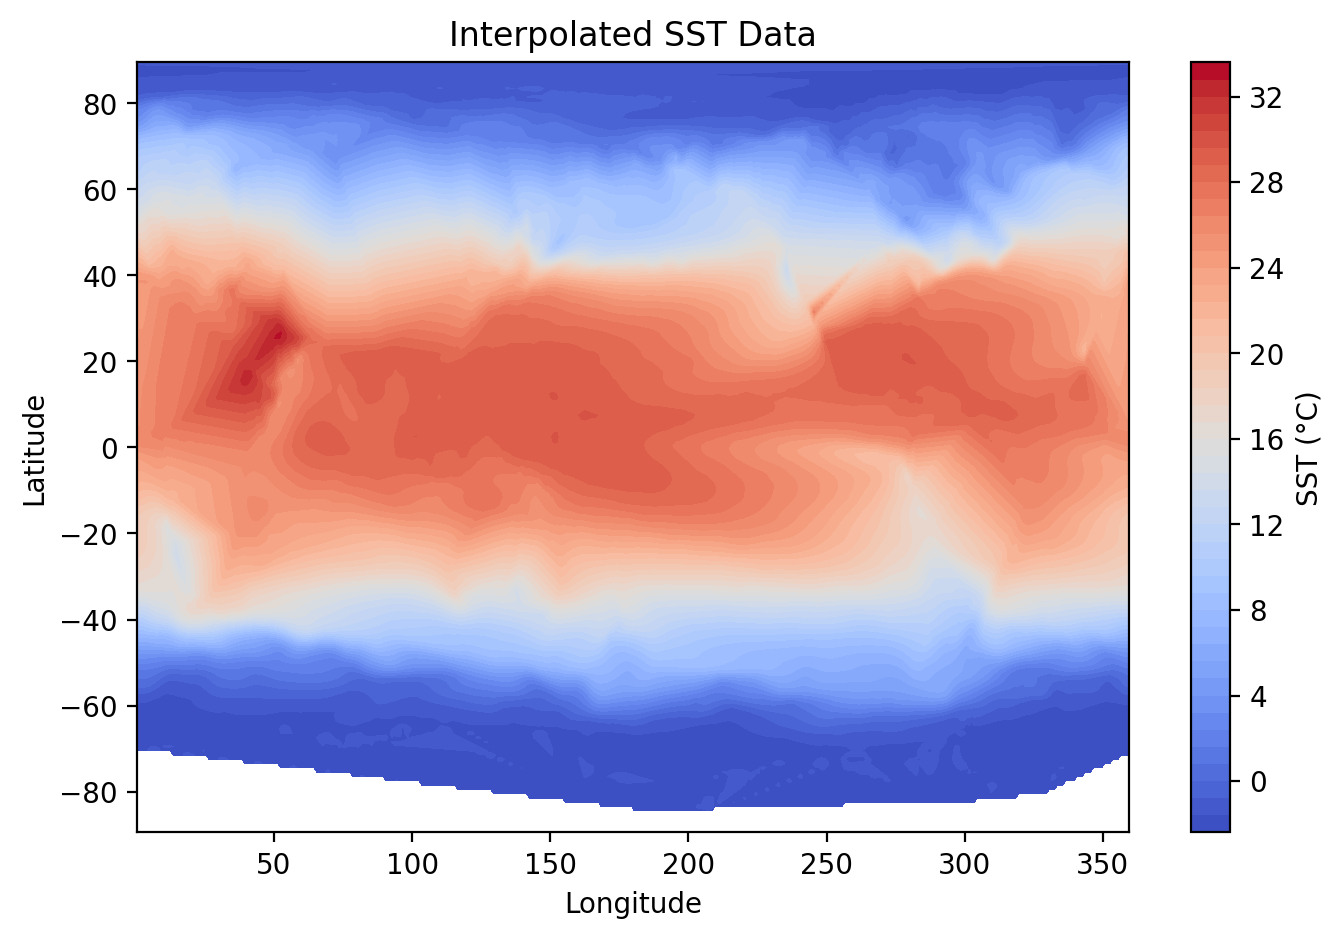

In [179]:
# Plot the interpolated SST data
plt.figure(figsize=(8, 5))
plt.contourf(full_lon_mesh, full_lat_mesh, interpolated_sst_sept, 50, cmap='coolwarm')
# Add labels
plt.title('Interpolated SST Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# Show Plot
plt.colorbar(label='SST (°C)')
plt.show()

**Step 4. Mask the ocean areas to show just the continents. You should end up with something cool!**

In [167]:
# Create land mask
# Load the ETOPO1 dataset
etopo_data = nc.Dataset('C:/Users/marzi/Downloads/etopo1.nc')

# Access the 'elevation' variable (or 'topography' variable) from ETOPO1
# This variable contains elevation data, with positive values for land and negative values for the ocean.
elevation = etopo_data['z'][:]

# Define the shape of your SST data
sst_shape = interpolated_sst_sept.shape

# Downsample the elevation data to match the shape of your SST data
elevation_downsampled = zoom(elevation, (sst_shape[0] / elevation.shape[0], sst_shape[1] / elevation.shape[1]))

# Create a land mask by comparing the downsampled elevation values with zero
land_mask = elevation_downsampled > 0   # Create a mask for land areas

In [168]:
# Mask out ocean areas by applying the land mask
interpolated_sst_sept_on_land = np.ma.masked_where(~land_mask, interpolated_sst_sept)

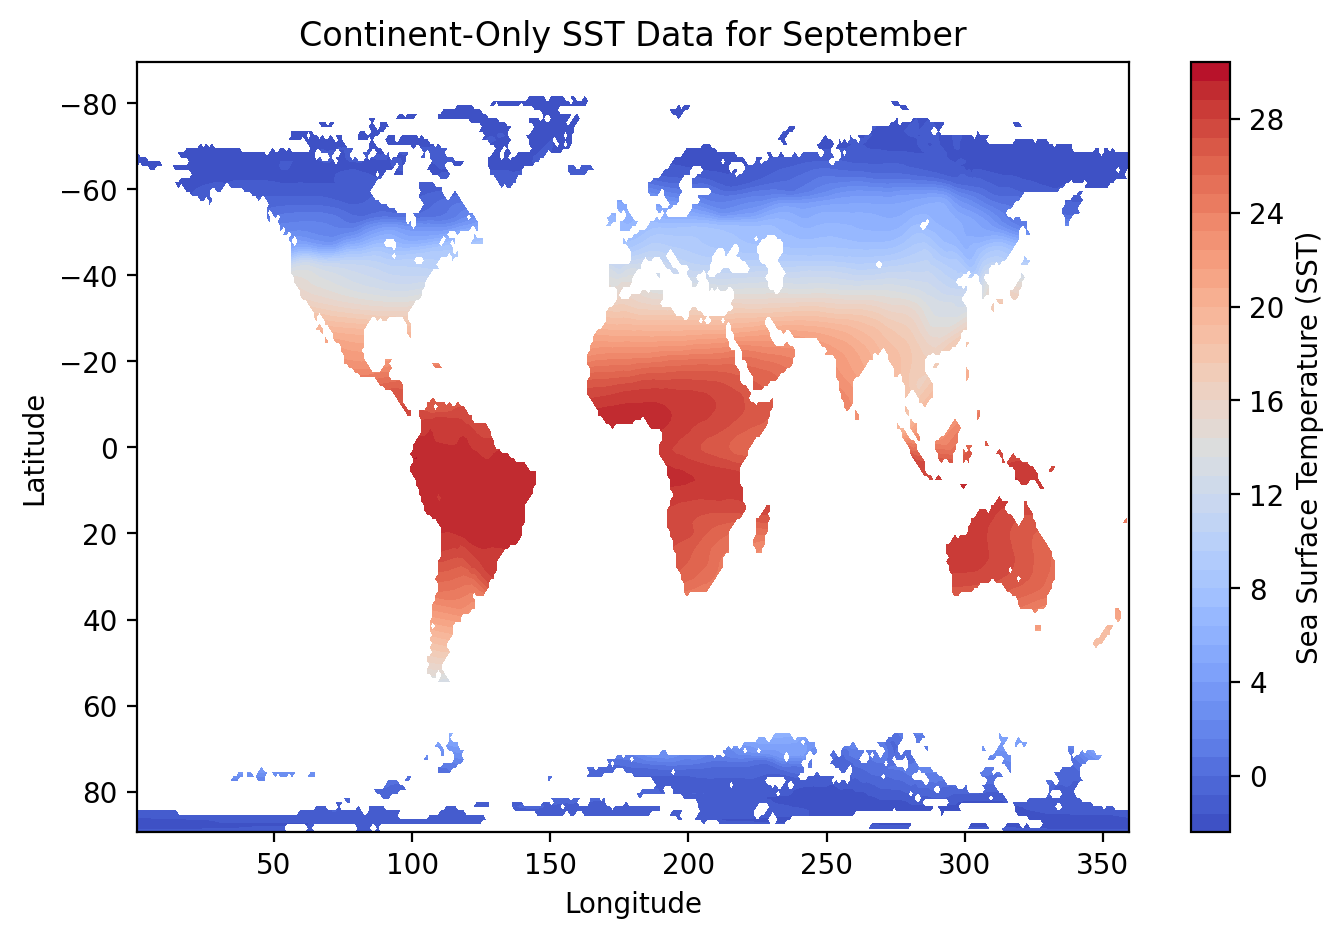

In [180]:
# Create a contour plot of the land areas with flipped Y-axis
plt.figure(figsize=(8, 5))
plt.contourf(full_lon_mesh, full_lat_mesh, interpolated_sst_sept_on_land, 50, cmap='coolwarm')
plt.gca().invert_yaxis()  # Flip the Y-axis
# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Continent-Only SST Data for September')
# Show the plot
plt.colorbar(label='Sea Surface Temperature (SST)')
plt.show()
